In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# 🏈 Predicting Blitzes Using Pre-Snap Behavior

**Authors:**  
- Chris Doyle (christopherdoyle@college.harvard.edu)  
- Hans Elasri (hanselasri@college.harvard.edu)  
- Thomas Garity (tgarity@college.harvard.edu)  
- Rishi Hazra (rishihazra@college.harvard.edu)  
- Chris Ruaño (cruano@college.harvard.edu)

---

## Project Summary

Blitzing is one of the most aggressive and high-risk strategies in football. When executed well, it can disrupt an offensive drive by forcing the quarterback into rushed decisions; when misread or mistimed, it can leave the defense vulnerable to big plays. Offensive coaches and quarterbacks spend countless hours studying pre-snap cues to anticipate incoming blitzes, while defenses work just as hard to disguise them through subtle shifts, delayed rushes, and simulated pressures.

Our project aims to bring analytics into this equation by predicting whether a defense will blitz, using only pre-snap player tracking data from the NFL Big Data Bowl 2025 dataset. By extracting features such as player positioning, movement trends, alignment depth, and formation structure, we seek to develop machine learning models that systematically classify plays as blitz or non-blitz scenarios. 

A successful model would not only help identify the most telling pre-snap indicators of pressure but also provide a practical tool for offensive strategists to better anticipate and counter defensive blitzes, enhancing both game preparation and real-time decision-making.

---

## Data Structure

Our data can be downloaded from the 2025 Big Data Bowl on [Kaggle](https://www.kaggle.com/competitions/nfl-big-data-bowl-2025/data)  
or using the Kaggle API:

```
kaggle competitions download -c nfl-big-data-bowl-2025
```

**Instructions:**
- Download the dataset and unzip the file `nfl-big-data-bowl-2025.zip`.
- The datasets will be saved in a `\nfl-big-data-bowl-2025` directory within the project repo.
- Ensure that this directory is listed in your `.gitignore` file to avoid pushing large data files to GitHub.

Now, let's check that the data has been downloaded correctly:

In [2]:
# ensure all tables downloaded
print("Data Availabe: ")
os.listdir('./nfl-big-data-bowl-2025/')

Data Availabe: 


['plays.csv',
 'tracking_week_5.csv',
 'tracking_week_4.csv',
 'tracking_week_6.csv',
 'tracking_week_7.csv',
 'tracking_week_3.csv',
 'tracking_week_2.csv',
 'tracking_week_1.csv',
 'players.csv',
 'games.csv',
 'tracking_week_9.csv',
 'tracking_week_8.csv',
 'player_play.csv']

In [3]:
!du -sh nfl-big-data-bowl-2025

7.6G	nfl-big-data-bowl-2025


In [4]:
# load datasets
plays_df = pd.read_csv('./nfl-big-data-bowl-2025/plays.csv')
players_df = pd.read_csv('./nfl-big-data-bowl-2025/players.csv')
games_df = pd.read_csv('./nfl-big-data-bowl-2025/games.csv')
player_play_df = pd.read_csv('./nfl-big-data-bowl-2025/player_play.csv')

In [5]:
# combine tracking data into one df
tracking_weeks = pd.DataFrame()
for week in range(1, 10):
    current_week = pd.read_csv(f'./nfl-big-data-bowl-2025/tracking_week_{week}.csv')
    tracking_weeks = pd.concat([tracking_weeks, current_week], ignore_index=True)

In [6]:
# randomly sample 30% gameId in games_df and filter plays_df, games_df, player_play_df, tracking_weeks
sampled_game_ids = games_df['gameId'].sample(frac=0.3, random_state=42)
plays_df = plays_df[plays_df['gameId'].isin(sampled_game_ids)]
games_df = games_df[games_df['gameId'].isin(sampled_game_ids)]
player_play_df = player_play_df[player_play_df['gameId'].isin(sampled_game_ids)]
tracking_weeks = tracking_weeks[tracking_weeks['gameId'].isin(sampled_game_ids)]

## Data Summary

### 1. `games.csv`
- **Purpose:** Info about each game.
- **Important Variables:**
  - `gameId` (primary key)
  - `season`, `week`
  - `homeTeamAbbr`, `visitorTeamAbbr`
- **Project Relevance:** Mostly for joining, basic game context (e.g., week, matchup). Not critical for blitz prediction itself.

---

### 2. `plays.csv`
- **Purpose:** Play-level metadata.
- **Important Variables:**
  - `gameId`, `playId` (keys)
  - `quarter`, `down`, `yardsToGo`
  - `possessionTeam`, `defensiveTeam`
  - `offenseFormation`
  - `playDescription`
  - `isDropback` (Boolean: did QB drop back)
  - `pff_passCoverage` (type of defensive coverage)
  - `pff_manZone` (man vs zone coverage)
  - `playAction` (play-action pass or not)
- **Project Relevance:** Crucial for understanding pre-snap situation and defensive alignment; used for labels or features in blitz prediction.

---

### 3. `players.csv`
- **Purpose:** Static player information.
- **Important Variables:**
  - `nflId` (player key)
  - `position`
  - `displayName`
- **Project Relevance:** Helpful for interpreting player roles; minor for pure blitz prediction unless modeling specific player tendencies.

---

### 4. `player_play.csv`
- **Purpose:** Player-level stats per play.
- **Important Variables:**
  - `gameId`, `playId`, `nflId` (keys)
  - `teamAbbr`
  - `wasInitialPassRusher` (binary, key for identifying blitzers!)
  - `causedPressure`
  - `timeToPressureAsPassRusher`
  - `getOffAsPassRusher`
- **Project Relevance:** Allows you to know who blitzed (extra rushers) and pressure dynamics.

---

### 5. `tracking_week_[1-9].csv`
- **Purpose:** Frame-by-frame tracking data (player movement).
- **Important Variables:**
  - `gameId`, `playId`, `nflId`
  - `frameId`, `time`
  - `x`, `y` (player positions)
  - `s`, `a`, `dis` (speed, acceleration, distance moved)
  - `o` (orientation) and `dir` (direction)
  - `event` (snap, ball release, etc.)
- **Project Relevance:** Used to generate **pre-snap features** like player alignments, movement, speed, and timing at snap. Core inputs for neural networks.


In [7]:
plays_df.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore',
       'playNullifiedByPenalty', 'absoluteYardlineNumber',
       'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
       'expectedPoints', 'offenseFormation', 'receiverAlignment',
       'playClockAtSnap', 'passResult', 'passLength', 'targetX', 'targetY',
       'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType',
       'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
       'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
       'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained',
       'yardsGained', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPointsAdded', 'isDropback',
       'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_runPassOption',
       'pff_pass

In [8]:
# drop unecessary cols
plays_df = plays_df.drop(columns=['playDescription', 'playNullifiedByPenalty', 'playClockAtSnap', 'passResult',
                                    'passLength', 'targetX', 'targetY', 'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType',
                                    'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
                                    'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
                                    'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained',
                                    'yardsGained', 'homeTeamWinProbabilityAdded',
                                    'visitorTeamWinProbilityAdded', 'expectedPointsAdded',
                                    'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_runPassOption',
                                    'pff_passCoverage', 'pff_manZone'])

In [9]:
# fill missing offensive formations
plays_df['offenseFormation'] = plays_df['offenseFormation'].fillna('EMPTY')

In [10]:
# convert game clock from MM:SS to total min
def convert_game_clock_to_minutes(game_clock):
    if pd.isna(game_clock):
        return np.nan
    minutes, seconds = map(int, game_clock.split(':'))
    return minutes + seconds / 60
plays_df['gameClock'] = plays_df['gameClock'].apply(convert_game_clock_to_minutes)
plays_df.head()

,gameId,playId,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,absoluteYardlineNumber,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,expectedPoints,offenseFormation,receiverAlignment,isDropback
1,2022091809,3698,4,1,10,CIN,DAL,CIN,8,2.216667,17,17,18,0.424356,0.575644,0.607746,EMPTY,3x2,True
6,2022110605,3861,4,1,10,IND,NE,IND,40,0.483333,26,3,50,0.997811,0.002189,0.991169,SHOTGUN,2x2,False
11,2022102306,3240,4,2,10,GB,WAS,WAS,46,12.916667,20,14,64,0.630746,0.369254,2.416086,SHOTGUN,3x1,False
12,2022091112,1674,2,1,10,GB,MIN,GB,25,0.583333,17,0,35,0.914143,0.085857,0.602453,EMPTY,4x1,True
14,2022092511,1310,2,2,7,ATL,SEA,SEA,38,9.683333,10,10,72,0.479273,0.520727,2.932096,PISTOL,2x1,True


In [11]:
# convert player heights from feet-inches to inches
def convert_height_to_inches(height):
    if pd.isna(height):
        return np.nan
    feet, inches = map(int, height.split('-'))
    return feet * 12 + inches
players_df['height'] = players_df['height'].apply(convert_height_to_inches)

In [12]:
# drop unecessary cols and set nflId as string
players_df = players_df.drop(columns=['birthDate', 'collegeName', 'displayName'])
players_df['nflId'] = players_df['nflId'].astype(str)
players_df.head()

,nflId,height,weight,position
0,25511,76,225,QB
1,29550,76,328,T
2,29851,74,225,QB
3,30842,78,267,TE
4,33084,76,217,QB


In [13]:
# drop unecessary cols
games_df = games_df.drop(columns=['season', 'gameDate', 'gameTimeEastern', 'homeFinalScore', 'visitorFinalScore'])
games_df.head()

,gameId,week,homeTeamAbbr,visitorTeamAbbr
0,2022090800,1,LA,BUF
4,2022091103,1,CIN,PIT
10,2022091110,1,ARI,KC
11,2022091111,1,LAC,LV
12,2022091112,1,MIN,GB


In [14]:
# set nflId as string
player_play_df['nflId'] = player_play_df['nflId'].astype(str)
player_play_df.head()

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,sackYardsAsOffense,hadPassReception,...,wasRunningRoute,routeRan,blockedPlayerNFLId1,blockedPlayerNFLId2,blockedPlayerNFLId3,pressureAllowedAsBlocker,timeToPressureAllowedAsBlocker,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId
0,2022090800,56,35472,BUF,0,0,0,0,0,0,...,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,2022090800,56,42392,BUF,0,0,0,0,0,0,...,NaN,NaN,47917.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,2022090800,56,42489,BUF,0,0,0,0,0,1,...,1.0,IN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022090800,56,44875,BUF,0,0,0,0,0,0,...,NaN,NaN,43335.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,2022090800,56,44985,BUF,0,0,0,0,0,0,...,1.0,OUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
player_play_df.columns

Index(['gameId', 'playId', 'nflId', 'teamAbbr', 'hadRushAttempt',
       'rushingYards', 'hadDropback', 'passingYards', 'sackYardsAsOffense',
       'hadPassReception', 'receivingYards', 'wasTargettedReceiver',
       'yardageGainedAfterTheCatch', 'fumbles', 'fumbleLost',
       'fumbleOutOfBounds', 'assistedTackle', 'forcedFumbleAsDefense',
       'halfSackYardsAsDefense', 'passDefensed', 'quarterbackHit',
       'sackYardsAsDefense', 'safetyAsDefense', 'soloTackle', 'tackleAssist',
       'tackleForALoss', 'tackleForALossYardage', 'hadInterception',
       'interceptionYards', 'fumbleRecoveries', 'fumbleRecoveryYards',
       'penaltyYards', 'penaltyNames', 'wasInitialPassRusher',
       'causedPressure', 'timeToPressureAsPassRusher',
       'getOffTimeAsPassRusher', 'inMotionAtBallSnap', 'shiftSinceLineset',
       'motionSinceLineset', 'wasRunningRoute', 'routeRan',
       'blockedPlayerNFLId1', 'blockedPlayerNFLId2', 'blockedPlayerNFLId3',
       'pressureAllowedAsBlocker', 'timeT

In [16]:
# select relevant play cols
player_play_df = player_play_df[['gameId', 'playId', 'nflId', 'teamAbbr', 'hadRushAttempt',
                                    'rushingYards', 'hadDropback', 'passingYards',
                                    'hadPassReception', 'receivingYards',
                                    'fumbles', 'forcedFumbleAsDefense',
                                    'quarterbackHit',
                                    'sackYardsAsDefense', 'soloTackle',
                                    'tackleForALoss', 'tackleForALossYardage', 'hadInterception',
                                    'interceptionYards', 'fumbleRecoveries',
                                    'penaltyYards', 'penaltyNames', 'wasInitialPassRusher',
                                    'causedPressure', 'timeToPressureAsPassRusher',
                                    'getOffTimeAsPassRusher', 'shiftSinceLineset',
                                    'motionSinceLineset',
                                    'blockedPlayerNFLId1', 'blockedPlayerNFLId2', 'blockedPlayerNFLId3',
                                    'pressureAllowedAsBlocker', 'timeToPressureAllowedAsBlocker']]

In [17]:
# set nlfId as string
player_play_df['nflId'] = player_play_df['nflId'].astype(str)
player_play_df.head()

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,hadPassReception,receivingYards,...,causedPressure,timeToPressureAsPassRusher,getOffTimeAsPassRusher,shiftSinceLineset,motionSinceLineset,blockedPlayerNFLId1,blockedPlayerNFLId2,blockedPlayerNFLId3,pressureAllowedAsBlocker,timeToPressureAllowedAsBlocker
0,2022090800,56,35472,BUF,0,0,0,0,0,0,...,False,NaN,NaN,False,False,47917.0,NaN,NaN,0.0,NaN
1,2022090800,56,42392,BUF,0,0,0,0,0,0,...,False,NaN,NaN,False,False,47917.0,NaN,NaN,0.0,NaN
2,2022090800,56,42489,BUF,0,0,0,0,1,6,...,False,NaN,NaN,False,True,NaN,NaN,NaN,NaN,NaN
3,2022090800,56,44875,BUF,0,0,0,0,0,0,...,False,NaN,NaN,False,False,43335.0,NaN,NaN,0.0,NaN
4,2022090800,56,44985,BUF,0,0,0,0,0,0,...,False,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN


In [18]:
tracking_weeks.head()

,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
1229350,2022091112,62,38632.0,Kirk Cousins,1,BEFORE_SNAP,2022-09-11 20:26:16.3,8.0,MIN,right,25.03,31.08,0.48,0.82,0.04,142.31,170.61,huddle_break_offense
1229351,2022091112,62,38632.0,Kirk Cousins,2,BEFORE_SNAP,2022-09-11 20:26:16.4,8.0,MIN,right,25.05,31.03,0.57,0.95,0.05,136.47,159.91,NaN
1229352,2022091112,62,38632.0,Kirk Cousins,3,BEFORE_SNAP,2022-09-11 20:26:16.5,8.0,MIN,right,25.08,30.97,0.72,1.19,0.07,129.16,149.34,NaN
1229353,2022091112,62,38632.0,Kirk Cousins,4,BEFORE_SNAP,2022-09-11 20:26:16.6,8.0,MIN,right,25.13,30.91,0.83,0.96,0.08,126.36,142.70,NaN
1229354,2022091112,62,38632.0,Kirk Cousins,5,BEFORE_SNAP,2022-09-11 20:26:16.7,8.0,MIN,right,25.19,30.84,0.96,1.05,0.09,119.27,137.30,NaN


In [19]:
# set nlfID as string after replacing ".0" with ""
tracking_weeks['nflId'] = tracking_weeks['nflId'].astype(str).str.replace('.0', '', regex=False)

In [20]:
tracking_weeks.columns

Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'frameType',
       'time', 'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a',
       'dis', 'o', 'dir', 'event'],
      dtype='object')

In [21]:
# select important tracking features
tracking_weeks = tracking_weeks[['gameId', 'playId', 'nflId', 'frameId', 'frameType',
                                    'playDirection', 'x', 'y', 's', 'a',
                                    'dis', 'o', 'dir', 'displayName']]

In [22]:
# replace ".0" in nflid with ""
tracking_weeks['nflId'] = tracking_weeks['nflId'].astype(str).str.replace('.0', '', regex=False)
tracking_weeks.head()

,gameId,playId,nflId,frameId,frameType,playDirection,x,y,s,a,dis,o,dir,displayName
1229350,2022091112,62,38632,1,BEFORE_SNAP,right,25.03,31.08,0.48,0.82,0.04,142.31,170.61,Kirk Cousins
1229351,2022091112,62,38632,2,BEFORE_SNAP,right,25.05,31.03,0.57,0.95,0.05,136.47,159.91,Kirk Cousins
1229352,2022091112,62,38632,3,BEFORE_SNAP,right,25.08,30.97,0.72,1.19,0.07,129.16,149.34,Kirk Cousins
1229353,2022091112,62,38632,4,BEFORE_SNAP,right,25.13,30.91,0.83,0.96,0.08,126.36,142.70,Kirk Cousins
1229354,2022091112,62,38632,5,BEFORE_SNAP,right,25.19,30.84,0.96,1.05,0.09,119.27,137.30,Kirk Cousins


In [23]:
# separate out tracking data without ball
tracking_weeks_without_ball = tracking_weeks[tracking_weeks['displayName'] != 'football']
tracking_weeks.drop(columns=['displayName'], inplace=True)
tracking_weeks_without_ball.drop(columns=['displayName'], inplace=True)
tracking_weeks_without_ball.head()

/var/folders/xr/1bg95zfj5hl_ln573zgvjmnm0000gn/T/ipykernel_62712/700578783.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_weeks_without_ball.drop(columns=['displayName'], inplace=True)


,gameId,playId,nflId,frameId,frameType,playDirection,x,y,s,a,dis,o,dir
1229350,2022091112,62,38632,1,BEFORE_SNAP,right,25.03,31.08,0.48,0.82,0.04,142.31,170.61
1229351,2022091112,62,38632,2,BEFORE_SNAP,right,25.05,31.03,0.57,0.95,0.05,136.47,159.91
1229352,2022091112,62,38632,3,BEFORE_SNAP,right,25.08,30.97,0.72,1.19,0.07,129.16,149.34
1229353,2022091112,62,38632,4,BEFORE_SNAP,right,25.13,30.91,0.83,0.96,0.08,126.36,142.70
1229354,2022091112,62,38632,5,BEFORE_SNAP,right,25.19,30.84,0.96,1.05,0.09,119.27,137.30


In [24]:
master_df = pd.DataFrame()

In [25]:
# merge player_play_df with players_df to get player names
master_df = player_play_df.merge(players_df[['nflId', 'position']], on='nflId', how='left')
master_df.head()

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,hadPassReception,receivingYards,...,timeToPressureAsPassRusher,getOffTimeAsPassRusher,shiftSinceLineset,motionSinceLineset,blockedPlayerNFLId1,blockedPlayerNFLId2,blockedPlayerNFLId3,pressureAllowedAsBlocker,timeToPressureAllowedAsBlocker,position
0,2022090800,56,35472,BUF,0,0,0,0,0,0,...,NaN,NaN,False,False,47917.0,NaN,NaN,0.0,NaN,G
1,2022090800,56,42392,BUF,0,0,0,0,0,0,...,NaN,NaN,False,False,47917.0,NaN,NaN,0.0,NaN,C
2,2022090800,56,42489,BUF,0,0,0,0,1,6,...,NaN,NaN,False,True,NaN,NaN,NaN,NaN,NaN,WR
3,2022090800,56,44875,BUF,0,0,0,0,0,0,...,NaN,NaN,False,False,43335.0,NaN,NaN,0.0,NaN,T
4,2022090800,56,44985,BUF,0,0,0,0,0,0,...,NaN,NaN,False,False,NaN,NaN,NaN,NaN,NaN,WR


In [26]:
# backup master_df for reuse
old_master_df = master_df.copy()
old_master_df['nflId'] = old_master_df['nflId'].astype(object)
old_master_df.to_csv('old_master_df.csv', index=False)
old_master_df = pd.read_csv('old_master_df.csv')
old_master_df['nflId'] = old_master_df['nflId'].astype(object)

In [27]:
# flatten rows with same gameid and playid by creating new columns per attribute per player
attr_cols = (
    player_play_df.columns[2:].tolist()
  + tracking_weeks.columns[3:].tolist()
  + players_df.columns[1:].tolist()
)
attr_cols = [c for c in dict.fromkeys(attr_cols) if c in master_df.columns]

# assign player slots per play
master_df['player_slot'] = (
    master_df
      .sort_values(['gameId','playId','nflId'])
      .groupby(['gameId','playId'])
      .cumcount()
    + 1
)

# pivot player stats into wide format
wide = (
    master_df
      .set_index(['gameId','playId','player_slot'])[attr_cols]
      .unstack('player_slot')
)

wide.columns = [
    f'{attr}_p{slot}'
    for attr, slot in wide.columns
]

wide = wide.reset_index()

expanded_players = wide

In [28]:
expanded_players.head()

,gameId,playId,nflId_p1,nflId_p2,nflId_p3,nflId_p4,nflId_p5,nflId_p6,nflId_p7,nflId_p8,...,position_p13,position_p14,position_p15,position_p16,position_p17,position_p18,position_p19,position_p20,position_p21,position_p22
0,2022090800,56,35472,38577,41239,42392,42489,42816,43294,43298,...,SS,RB,TE,NT,SS,C,WR,FS,T,ILB
1,2022090800,80,35472,38577,41239,42392,42489,42816,43294,43298,...,SS,RB,TE,NT,SS,C,WR,FS,T,ILB
2,2022090800,101,35472,38577,41239,42392,42816,42818,43294,43298,...,RB,CB,TE,NT,OLB,SS,C,WR,FB,T
3,2022090800,122,35472,38577,41239,42392,42489,42816,43294,43298,...,SS,RB,CB,TE,NT,OLB,SS,C,WR,T
4,2022090800,167,35472,38577,41239,42392,42489,42816,43294,43298,...,SS,CB,TE,NT,OLB,SS,C,RB,WR,T


In [29]:
# merge player_play_df with plays_df on both playId and gameId
expanded_players = expanded_players.merge(plays_df, on=['playId', 'gameId'], how='left')
expanded_players.head()

,gameId,playId,nflId_p1,nflId_p2,nflId_p3,nflId_p4,nflId_p5,nflId_p6,nflId_p7,nflId_p8,...,gameClock,preSnapHomeScore,preSnapVisitorScore,absoluteYardlineNumber,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,expectedPoints,offenseFormation,receiverAlignment,isDropback
0,2022090800,56,35472,38577,41239,42392,42489,42816,43294,43298,...,15.000000,0,0,85,0.413347,0.586653,1.298699,SHOTGUN,2x2,True
1,2022090800,80,35472,38577,41239,42392,42489,42816,43294,43298,...,14.483333,0,0,79,0.413316,0.586684,1.303119,EMPTY,3x2,True
2,2022090800,101,35472,38577,41239,42392,42816,42818,43294,43298,...,13.900000,0,0,72,0.399819,0.600181,2.126690,I_FORM,2x1,False
3,2022090800,122,35472,38577,41239,42392,42489,42816,43294,43298,...,13.250000,0,0,65,0.384969,0.615031,2.689053,SHOTGUN,2x1,True
4,2022090800,167,35472,38577,41239,42392,42489,42816,43294,43298,...,11.900000,0,0,57,0.387554,0.612446,2.574206,EMPTY,3x2,True


In [30]:
# merge master_df with games_df on gameId
expanded_players = expanded_players.merge(games_df, on='gameId', how='left')
expanded_players.head()

,gameId,playId,nflId_p1,nflId_p2,nflId_p3,nflId_p4,nflId_p5,nflId_p6,nflId_p7,nflId_p8,...,absoluteYardlineNumber,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,expectedPoints,offenseFormation,receiverAlignment,isDropback,week,homeTeamAbbr,visitorTeamAbbr
0,2022090800,56,35472,38577,41239,42392,42489,42816,43294,43298,...,85,0.413347,0.586653,1.298699,SHOTGUN,2x2,True,1,LA,BUF
1,2022090800,80,35472,38577,41239,42392,42489,42816,43294,43298,...,79,0.413316,0.586684,1.303119,EMPTY,3x2,True,1,LA,BUF
2,2022090800,101,35472,38577,41239,42392,42816,42818,43294,43298,...,72,0.399819,0.600181,2.126690,I_FORM,2x1,False,1,LA,BUF
3,2022090800,122,35472,38577,41239,42392,42489,42816,43294,43298,...,65,0.384969,0.615031,2.689053,SHOTGUN,2x1,True,1,LA,BUF
4,2022090800,167,35472,38577,41239,42392,42489,42816,43294,43298,...,57,0.387554,0.612446,2.574206,EMPTY,3x2,True,1,LA,BUF


In [31]:
# save non-time-varying data
nontime_data = expanded_players.copy()
nontime_data.to_csv('nontime_data.csv', index=False)

In [32]:
nontime_data.head()

,gameId,playId,nflId_p1,nflId_p2,nflId_p3,nflId_p4,nflId_p5,nflId_p6,nflId_p7,nflId_p8,...,absoluteYardlineNumber,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,expectedPoints,offenseFormation,receiverAlignment,isDropback,week,homeTeamAbbr,visitorTeamAbbr
0,2022090800,56,35472,38577,41239,42392,42489,42816,43294,43298,...,85,0.413347,0.586653,1.298699,SHOTGUN,2x2,True,1,LA,BUF
1,2022090800,80,35472,38577,41239,42392,42489,42816,43294,43298,...,79,0.413316,0.586684,1.303119,EMPTY,3x2,True,1,LA,BUF
2,2022090800,101,35472,38577,41239,42392,42816,42818,43294,43298,...,72,0.399819,0.600181,2.126690,I_FORM,2x1,False,1,LA,BUF
3,2022090800,122,35472,38577,41239,42392,42489,42816,43294,43298,...,65,0.384969,0.615031,2.689053,SHOTGUN,2x1,True,1,LA,BUF
4,2022090800,167,35472,38577,41239,42392,42489,42816,43294,43298,...,57,0.387554,0.612446,2.574206,EMPTY,3x2,True,1,LA,BUF


In [33]:
# print nflId data types in master_df and old_master_df
print("tracking_weeks nflId data type: ", tracking_weeks['nflId'].dtype)
print("old_master_df nflId data type: ", old_master_df['nflId'].dtype)

tracking_weeks nflId data type:  object
old_master_df nflId data type:  object


In [34]:
# merge master_df with tracking_weeks on gameId, playId, and nflId
master_df = old_master_df.merge(tracking_weeks, on=['gameId', 'playId', 'nflId'], how='left')
master_df.head()

,gameId,playId,nflId,teamAbbr,hadRushAttempt,rushingYards,hadDropback,passingYards,hadPassReception,receivingYards,...,frameId,frameType,playDirection,x,y,s,a,dis,o,dir
0,2022090800,56,35472,BUF,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022090800,56,42392,BUF,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022090800,56,42489,BUF,0,0,0,0,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022090800,56,44875,BUF,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022090800,56,44985,BUF,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
tracking_weeks.columns

Index(['gameId', 'playId', 'nflId', 'frameId', 'frameType', 'playDirection',
       'x', 'y', 's', 'a', 'dis', 'o', 'dir'],
      dtype='object')

We utilize only BEFORE_SNAP data, as it represents the complete set of information accessible when the decision to blitz must be made during actual gameplay.

In [36]:
# filter tracking data to pre-snap frames only
tracking_weeks_without_ball = tracking_weeks_without_ball[tracking_weeks_without_ball['frameType'] == 'BEFORE_SNAP']

In [37]:
# merge tracking data (x,y,s,a,dir) into wide format
attr_cols = (
       ['x', 'y', 's', 'a', 'dis', 'o', 'dir']
)

attr_cols = [c for c in dict.fromkeys(attr_cols) if c in tracking_weeks_without_ball.columns]
tracking_weeks_without_ball['player_slot'] = (
    tracking_weeks_without_ball
      .sort_values(['gameId','playId','nflId'])    # or whatever ordering you prefer
      .groupby(['gameId','playId', 'frameId'])
      .cumcount()
    + 1
)

wide = (
    tracking_weeks_without_ball
      .set_index(['gameId','playId', 'frameId', 'player_slot'])[attr_cols]
      .unstack('player_slot')
)

wide.columns = [
    f'{attr}_p{slot}'
    for attr, slot in wide.columns
]

wide = wide.reset_index()

tracking_weeks_without_ball = wide

In [38]:
tracking_weeks_without_ball.head()

,gameId,playId,frameId,x_p1,x_p2,x_p3,x_p4,x_p5,x_p6,x_p7,...,dir_p13,dir_p14,dir_p15,dir_p16,dir_p17,dir_p18,dir_p19,dir_p20,dir_p21,dir_p22
0,2022090800,56,1,89.48,81.93,82.90,88.80,91.08,82.05,81.60,...,200.63,169.95,320.02,306.81,242.41,280.71,168.74,328.45,293.55,317.86
1,2022090800,56,2,89.39,81.83,82.85,88.59,91.06,81.97,81.54,...,198.46,171.35,319.98,306.45,244.46,281.67,170.11,328.51,293.95,312.00
2,2022090800,56,3,89.28,81.73,82.80,88.38,91.04,81.89,81.48,...,195.91,173.34,318.91,310.47,245.36,282.33,171.82,328.92,294.58,304.65
3,2022090800,56,4,89.15,81.62,82.77,88.18,91.01,81.81,81.41,...,194.20,173.88,318.35,321.06,245.46,282.62,173.48,330.85,295.03,297.01
4,2022090800,56,5,89.00,81.50,82.74,87.99,90.97,81.73,81.34,...,192.81,175.64,317.23,337.88,244.06,282.70,176.03,333.96,295.55,291.28


In [39]:
# merge tracking_weeks_without_ball with master_df on gameId, playId
master_df = nontime_data.merge(tracking_weeks_without_ball, on=['gameId', 'playId'], how='outer')
master_df.to_csv('master_df.csv', index=False)

In [40]:
master_df.head()

,gameId,playId,nflId_p1,nflId_p2,nflId_p3,nflId_p4,nflId_p5,nflId_p6,nflId_p7,nflId_p8,...,dir_p13,dir_p14,dir_p15,dir_p16,dir_p17,dir_p18,dir_p19,dir_p20,dir_p21,dir_p22
0,2022090800,56,35472,38577,41239,42392,42489,42816,43294,43298,...,200.63,169.95,320.02,306.81,242.41,280.71,168.74,328.45,293.55,317.86
1,2022090800,56,35472,38577,41239,42392,42489,42816,43294,43298,...,198.46,171.35,319.98,306.45,244.46,281.67,170.11,328.51,293.95,312.00
2,2022090800,56,35472,38577,41239,42392,42489,42816,43294,43298,...,195.91,173.34,318.91,310.47,245.36,282.33,171.82,328.92,294.58,304.65
3,2022090800,56,35472,38577,41239,42392,42489,42816,43294,43298,...,194.20,173.88,318.35,321.06,245.46,282.62,173.48,330.85,295.03,297.01
4,2022090800,56,35472,38577,41239,42392,42489,42816,43294,43298,...,192.81,175.64,317.23,337.88,244.06,282.70,176.03,333.96,295.55,291.28


## Blitz Labeling Methodology

To label whether a play is a blitz, we adopt a method inspired by Dominic Borsani’s approach in the 2023 NFL Big Data Bowl. Rather than relying directly on provided scouting labels, we infer blitz likelihood based on **pre-snap defender behavior** observable in the tracking data.

Specifically, we use the following steps:

- Merge tracking data (`tracking_week_*`) with play metadata from `plays.csv` to access line of scrimmage (`LOS`) information.
- Identify **frames where `frameType == 'SNAP'`**, which correspond to the official ball snap moment.
- For each defender at ball snap:
  - **Distance from LOS**: Compute the absolute difference between the player’s `x` coordinate and the line of scrimmage (`LOS_x`), adjusted for play direction.
  - **Motion Toward LOS**: Estimate whether a player is moving toward the ball using the `dir` (direction) and `playDirection`.
  - **Velocity Toward LOS**: Calculate as `speed × motion_toward_ball`.
- A defender is flagged as a **likely blitzer** if:
  - They are **within 5 yards** of the line of scrimmage at the snap, **and**
  - They are **moving toward the LOS at greater than 1.5 yards per second**.
- At the play level, we sum the number of players flagged as likely blitzers.

We define a **blitz play** as one where **more than 1 defender** meets the blitz criteria at the snap.  
This threshold aligns with the intuition that sending multiple extra rushers constitutes a true blitz rather than just a normal pass rush.

---

### Reference

Borsani, D. (2023). *Beat the Offensive Line: Using Data to Determine Blitz Strategy.* NFL Big Data Bowl, Finalist Project.


In [41]:
# count unique plays
unique_plays = tracking_weeks[['gameId', 'playId']].drop_duplicates()
print(f"Number of unique plays: {len(unique_plays)}")

Number of unique plays: 4886


In [42]:
plays_subset = plays_df[['gameId', 'playId', 'yardlineNumber', 'yardlineSide', 'absoluteYardlineNumber']]
tracking = tracking_weeks.merge(plays_subset, on=['gameId', 'playId'], how='left')

# keep only frames right at ball snap
snap_tracking = tracking[tracking['frameType'] == 'SNAP']

# calculate LOS x-coordinate
def calculate_los_x(playDirection, absoluteYardlineNumber):
    if playDirection == 'left':
        return 100 - absoluteYardlineNumber
    else:
        return absoluteYardlineNumber

snap_tracking['LOS_x'] = snap_tracking.apply(
    lambda row: calculate_los_x(row['playDirection'], row['absoluteYardlineNumber']), axis=1
)

# distance from LOS
snap_tracking['dist_from_LOS'] = np.abs(snap_tracking['x'] - snap_tracking['LOS_x'])

# motion toward ball based on play direction
def motion_toward_ball(row):
    if row['playDirection'] == 'left':
        return np.cos(np.deg2rad(row['dir']))
    else:
        return np.cos(np.deg2rad(row['dir'] - 180))

snap_tracking['motion_toward_ball'] = snap_tracking.apply(motion_toward_ball, axis=1)

# velocity toward LOS
snap_tracking['velocity_toward_LOS'] = snap_tracking['s'] * snap_tracking['motion_toward_ball']

# likely blitzer = close to LOS and moving fast toward ball
snap_tracking['isLikelyBlitzer'] = (
    (snap_tracking['dist_from_LOS'] <= 5) &
    (snap_tracking['velocity_toward_LOS'] > 1.5)
).astype(int)

# count likely blitzers
num_likely_blitzers = snap_tracking['isLikelyBlitzer'].sum()
print(f"Total number of players flagged as likely blitzers: {num_likely_blitzers}")

# count blitzers per play
blitzer_counts_by_play = snap_tracking.groupby(['gameId', 'playId'])['isLikelyBlitzer'].sum().reset_index()
print(blitzer_counts_by_play.head())

/var/folders/xr/1bg95zfj5hl_ln573zgvjmnm0000gn/T/ipykernel_62712/1063028119.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snap_tracking['LOS_x'] = snap_tracking.apply(
/var/folders/xr/1bg95zfj5hl_ln573zgvjmnm0000gn/T/ipykernel_62712/1063028119.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snap_tracking['dist_from_LOS'] = np.abs(snap_tracking['x'] - snap_tracking['LOS_x'])


Total number of players flagged as likely blitzers: 544
       gameId  playId  isLikelyBlitzer
0  2022090800      56                0
1  2022090800      80                0
2  2022090800     101                0
3  2022090800     122                0
4  2022090800     167                0


/var/folders/xr/1bg95zfj5hl_ln573zgvjmnm0000gn/T/ipykernel_62712/1063028119.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snap_tracking['motion_toward_ball'] = snap_tracking.apply(motion_toward_ball, axis=1)
/var/folders/xr/1bg95zfj5hl_ln573zgvjmnm0000gn/T/ipykernel_62712/1063028119.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snap_tracking['velocity_toward_LOS'] = snap_tracking['s'] * snap_tracking['motion_toward_ball']
/var/folders/xr/1bg95zfj5hl_ln573zgvjmnm0000gn/T/ipykernel_62712/1063028

In [43]:
# count plays with 1+ blitzer
plays_with_blitzers = blitzer_counts_by_play[blitzer_counts_by_play['isLikelyBlitzer'] > 0]
num_plays_with_blitzers = len(plays_with_blitzers)

# Count total unique plays
total_plays = len(blitzer_counts_by_play)

# calculate percentage
blitz_percentage = (num_plays_with_blitzers / total_plays) * 100 if total_plays > 0 else 0

print(f"Total plays: {total_plays}")
print(f"Plays with at least one blitzer: {num_plays_with_blitzers}")
print(f"Percentage of plays with blitzers: {blitz_percentage:.2f}%")

# count pass plays
pass_plays = plays_df[plays_df['isDropback'] == 1]
print(f"Number of pass plays: {len(pass_plays)}")

# calculate percentage of pass plays with blitzers
pass_plays_with_blitzers = pass_plays[pass_plays['playId'].isin(plays_with_blitzers['playId'])]
num_pass_plays_with_blitzers = len(pass_plays_with_blitzers)
pass_plays_total = len(pass_plays)
pass_blitz_percentage = (num_pass_plays_with_blitzers / pass_plays_total) * 100 if pass_plays_total > 0 else 0
print(f"Total pass plays: {pass_plays_total}")
print(f"Pass plays with at least one blitzer: {num_pass_plays_with_blitzers}")
print(f"Percentage of pass plays with blitzers: {pass_blitz_percentage:.2f}%")

# breakdown of plays by number of blitzers
blitzer_distribution = blitzer_counts_by_play['isLikelyBlitzer'].value_counts().sort_index()
print("\nDistribution of blitzers per play:")
print(blitzer_distribution)

# classify plays as blitzes if > threshold_for_blitz_play likely blitzers
threshold_for_blitz_play = 1
plays_with_significant_blitz = blitzer_counts_by_play[blitzer_counts_by_play['isLikelyBlitzer'] > threshold_for_blitz_play]
print(f"\nPlays with more than {threshold_for_blitz_play} blitzer(s): {len(plays_with_significant_blitz)}")
print(f"Percentage: {(len(plays_with_significant_blitz) / total_plays) * 100:.2f}%")

Total plays: 4886
Plays with at least one blitzer: 351
Percentage of plays with blitzers: 7.18%
Number of pass plays: 3049
Total pass plays: 3049
Pass plays with at least one blitzer: 426
Percentage of pass plays with blitzers: 13.97%

Distribution of blitzers per play:
isLikelyBlitzer
0    4535
1     205
2     112
3      25
4       6
5       2
6       1
Name: count, dtype: int64

Plays with more than 1 blitzer(s): 146
Percentage: 2.99%


In [44]:
blitzer_counts_by_play.head()

,gameId,playId,isLikelyBlitzer
0,2022090800,56,0
1,2022090800,80,0
2,2022090800,101,0
3,2022090800,122,0
4,2022090800,167,0


In [45]:
# set output to 1 if isLikelyBlitzer > threshold_for_blitz_play else 0
blitz_outcome = blitzer_counts_by_play.copy()
blitz_outcome['blitzOutcome'] = blitz_outcome['isLikelyBlitzer'].apply(lambda x: 1 if x >= threshold_for_blitz_play else 0)
blitz_outcome = blitz_outcome[['gameId', 'playId', 'blitzOutcome']]
blitz_outcome = blitz_outcome.drop_duplicates()
blitz_outcome = blitz_outcome.dropna()
blitz_outcome.head()

,gameId,playId,blitzOutcome
0,2022090800,56,0
1,2022090800,80,0
2,2022090800,101,0
3,2022090800,122,0
4,2022090800,167,0


## Exploratory Data Analysis (EDA)

In this section, we examine patterns in key pre-snap features that are likely to correlate with defender blitz behavior. By comparing blitzers to non-blitzers across these dimensions, we validate that these features are meaningful predictors and align our modeling approach with how quarterbacks and offensive coordinators would realistically assess defensive pressure pre-snap.

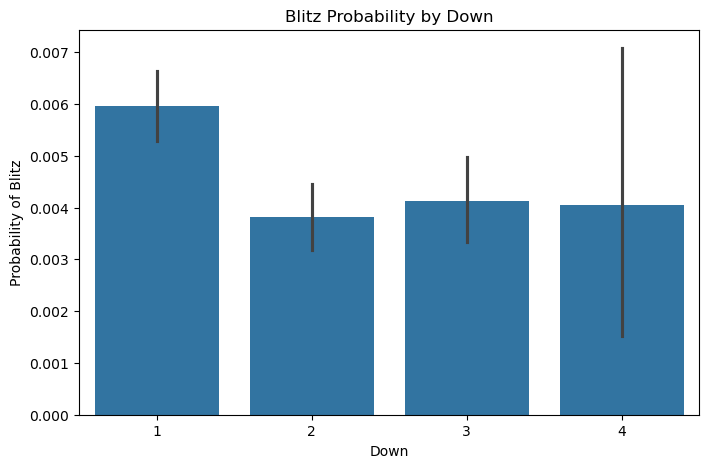

In [ ]:
# blitz prob by down
snap_with_down = snap_tracking.merge(plays_df[['gameId', 'playId', 'down']], on=['gameId', 'playId'], how='left')

plt.figure(figsize=(8,5))
sns.barplot(data=snap_with_down, x='down', y=snap_with_down['isLikelyBlitzer'].astype(int), estimator=np.mean)
plt.title('Blitz Probability by Down')
plt.ylabel('Probability of Blitz')
plt.xlabel('Down')
plt.show()

Blitz probability appears slightly higher on 1st down compared to other downs, suggesting that defenses in this sample may be using early-down blitzes to create unexpected pressure. The overall blitz rate remains very low across all downs, indicating that blitzing is a relatively rare event and not strictly tied to down-and-distance situations.

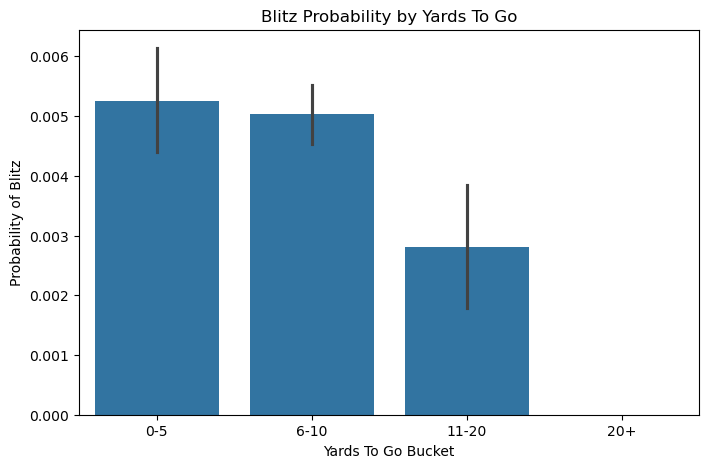

In [ ]:
# blitz prob by yards to go bucket
snap_with_yards = snap_tracking.merge(plays_df[['gameId', 'playId', 'yardsToGo']], on=['gameId', 'playId'], how='left')
snap_with_yards['yards_bucket'] = pd.cut(snap_with_yards['yardsToGo'], bins=[0,5,10,20,50], labels=['0-5','6-10','11-20','20+'])

plt.figure(figsize=(8,5))
sns.barplot(data=snap_with_yards, x='yards_bucket', y=snap_with_yards['isLikelyBlitzer'].astype(int), estimator=np.mean)
plt.title('Blitz Probability by Yards To Go')
plt.ylabel('Probability of Blitz')
plt.xlabel('Yards To Go Bucket')
plt.show()

Blitz probability is slightly higher when the offense faces short-to-medium distances (0–5 yards and 6–10 yards) compared to longer yardage situations. This suggests that defenses may prefer to pressure the quarterback early on manageable downs rather than taking risks against longer-yardage plays. However, overall blitz probability remains low across all yardage ranges, reinforcing that pre-snap player motion and alignment will be key for better blitz prediction.

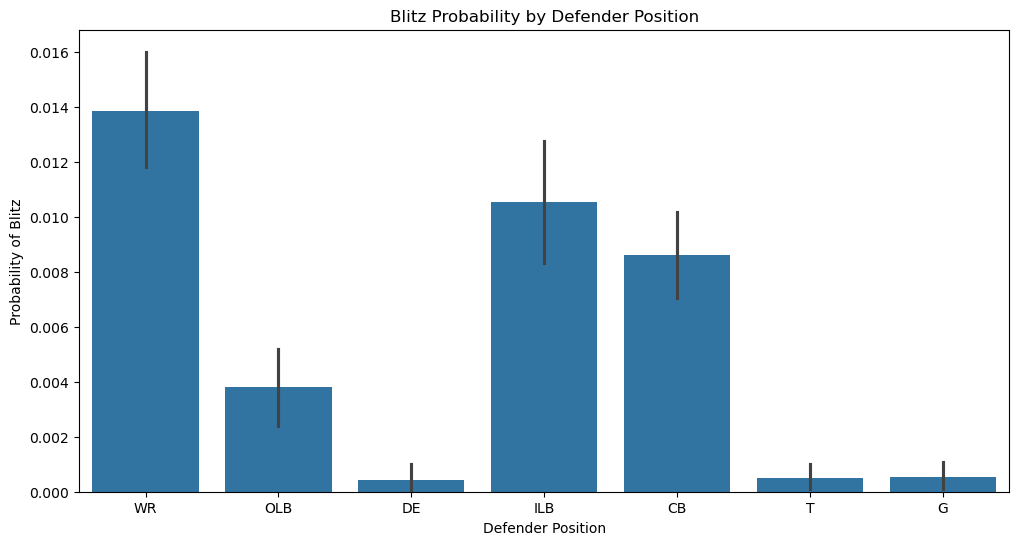

In [69]:
snap_with_position = snap_tracking.merge(players_df[['nflId', 'position']], on='nflId', how='left')

top_positions = snap_with_position['position'].value_counts().head(7).index.tolist()
snap_with_position = snap_with_position[snap_with_position['position'].isin(top_positions)]

plt.figure(figsize=(12,6))
sns.barplot(data=snap_with_position, x='position', y=snap_with_position['isLikelyBlitzer'].astype(int), estimator=np.mean)
plt.title('Blitz Probability by Defender Position')
plt.ylabel('Probability of Blitz')
plt.xlabel('Defender Position')
plt.show()

# Gotta fix preprocessing.

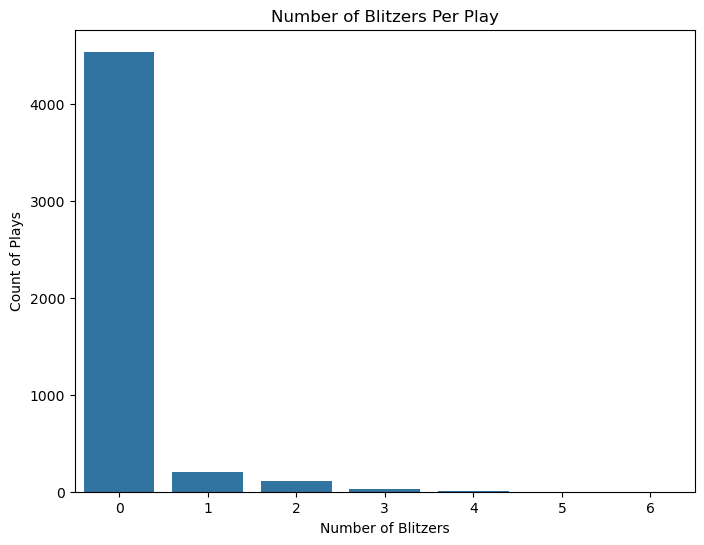

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=blitzer_counts_by_play, x='isLikelyBlitzer')
plt.title('Number of Blitzers Per Play')
plt.xlabel('Number of Blitzers')
plt.ylabel('Count of Plays')
plt.show()

Plays with one or more likely blitzers occur much less frequently, and instances of multiple simultaneous blitzers (2, 3, or more) are very rare. This distribution reinforces the need to handle class imbalance carefully when building predictive models, and it suggests that additional pre-snap cues beyond simple player counts are necessary to predict blitzes accurately.

## Modeling

### Objective

We attempt to predict whether a **defender will blitz** (`isLikelyBlitzer = 1`) based **only on information available before the snap**. In NFL game situations, quarterbacks and offensive coordinators must make real-time protection adjustments based on pre-snap alignments, player movement, and game context. To mirror this reality, our model is strictly limited to **pre-snap observable features**.

---

## Feature Selection

Our features are selected based on what a quarterback or coach could realistically observe live:

- **Tracking Data (Pre-Snap, `tracking_week_*`)**:
  - `x`, `y`: Player's location on the field at the snap.
  - `s`: Player speed (yards/second) — shows if a defender is creeping forward.
  - `a`: Player acceleration (yards/second²) — sudden movement may indicate blitz.
  - `dis`: Distance traveled since the prior frame.
  - `o`: Player orientation (which direction their body is facing).
  - `dir`: Direction of player motion.

- **Play Metadata (`plays.csv`)**:
  - `down`: Current down (1st, 2nd, 3rd, 4th) — blitzes more common on late downs.
  - `yardsToGo`: Distance to first down — long distances can encourage blitzing.
  - `playClockAtSnap`: Remaining play clock time — last-second snaps may alter defensive behavior.
  - `offenseFormation`: Offensive alignment (categorical).
  - `pff_passCoverage`: Defensive coverage scheme (categorical).
  - `pff_manZone`: Whether the defense was playing man or zone.

- **Player Metadata (`players.csv`)**:
  - `position`: Player position group (e.g., LB, CB, S, DE).

All categorical variables are **one-hot encoded** to integrate cleanly with our modeling approach.

By using only pre-snap tracking and contextual information, the model realistically approximates how a quarterback or coach would scout for potential blitzers in real time.

---

## Preprocessing Steps

1. **Filter to defenders only**: Identify players on the defensive team (`club != possessionTeam`).
2. **Restrict frames** to `frameType == 'SNAP'`: Capture exact alignment and motion at the moment of the snap.
3. **Merge metadata**: Add player position and play context (down, distance, formation, coverage).
4. **Handle missing values**: Fill missing categorical fields (e.g., `offenseFormation`) with "Unknown".
5. **One-hot encode** categorical features: Transform `position`, `offenseFormation`, `pff_passCoverage`, and `pff_manZone`.
6. **Prepare X and y**:
   - **X**: Pre-snap physical and contextual features.
   - **y**: Binary label (`isLikelyBlitzer`), engineered from motion and distance heuristics.

---

## Baseline Model

- **Model:** Logistic Regression
- **Class Imbalance Handling:** 
  - Apply `class_weight='balanced'` to automatically adjust for the minority class (blitzers).
  - This prevents the model from simply predicting "no blitz" every time, and encourages sensitivity to rare blitz behaviors.
- **Train-Test Split:** 
  - 80% of data used for training, 20% held out for testing.
  - Stratified sampling is used to preserve the blitz/non-blitz ratio.

In [ ]:
master_df = pd.read_csv('master_df.csv')
nontime_data = pd.read_csv('nontime_data.csv')

In [ ]:
nontime_data.head()

In [ ]:
# fill all missing categorical fields
categorical_cols = []
for col in nontime_data.select_dtypes(include=['object']).columns:
    if col not in ['gameId', 'playId', 'nflId']:
        categorical_cols.append(col)
for col in categorical_cols:
    nontime_data[col] = nontime_data[col].fillna('Unknown')

# one-hot encode categorical cols
snap_tracking_encoded = pd.get_dummies(
    nontime_data,
    columns=categorical_cols,
    drop_first=True
)

# sort data by gameId and playId 
snap_tracking_encoded.sort_values(['gameId', 'playId'])

In [ ]:
# prepare feature matrix X by dropping ID cols
X = snap_tracking_encoded.drop(columns=['gameId', 'playId'])

# drop any remaining object-type columns from X
for col in X.select_dtypes(include=['object']).columns:
    X = X.drop(columns=[col])

# Sort target variable by gameId and playId to match X
blitz_outcome = blitz_outcome.sort_values(['gameId', 'playId'])
y = blitz_outcome['blitzOutcome']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=109)

In [ ]:
# impute missing values annd adjust for class imbalance
pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),           
    LogisticRegression(max_iter=1000,
                       class_weight='balanced')
)

In [ ]:
# logistic regression
logreg = pipeline.fit(X_train, y_train)

In [ ]:
# evaluate results
y_pred = logreg.predict(X_test)
print("Classification Report (Logistic Regression Baseline):")
print(classification_report(y_test, y_pred))

In [ ]:
# test on a few plays
